In [1]:
import tensorflow as tf ### models
import numpy as np ### math computations
import matplotlib.pyplot as plt ### plotting bar chart
import sklearn ### machine learning library
import cv2 ## image processing
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score ### metrics
import seaborn as sns ### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image

#import tensorflow_probability as tfp
import tensorflow_datasets as tfds

import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorflow.keras.metrics import BinaryAccuracy,FalseNegatives,FalsePositives,TruePositives,TrueNegatives,Precision,Recall,AUC

In [4]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 200,
    "LEARNING_RATE": .001,
    "N_EPOCHS": 30,
    "DROPOUT_RATE": 0.5,
    "REGULARIZATION_RATE": 0.1,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 5,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["Lung_","Limbs_","Brain_","Breast_"]
}

In [4]:
train_directory = r"ai\Train_"
val_directory = r"ai\Valid_"
test_directory=r"ai\Test_"

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_directory,

    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=5,


)


Found 8000 files belonging to 4 classes.


In [8]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_directory,

    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=5,


)


Found 1000 files belonging to 4 classes.


In [6]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
     test_directory,

    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=5,

)

Found 988 files belonging to 4 classes.


In [7]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [8]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [9]:
CONFIGURATION["CLASS_NAMES"][tf.argmax([1,0,0], axis = 0).numpy()]

'Lung_'

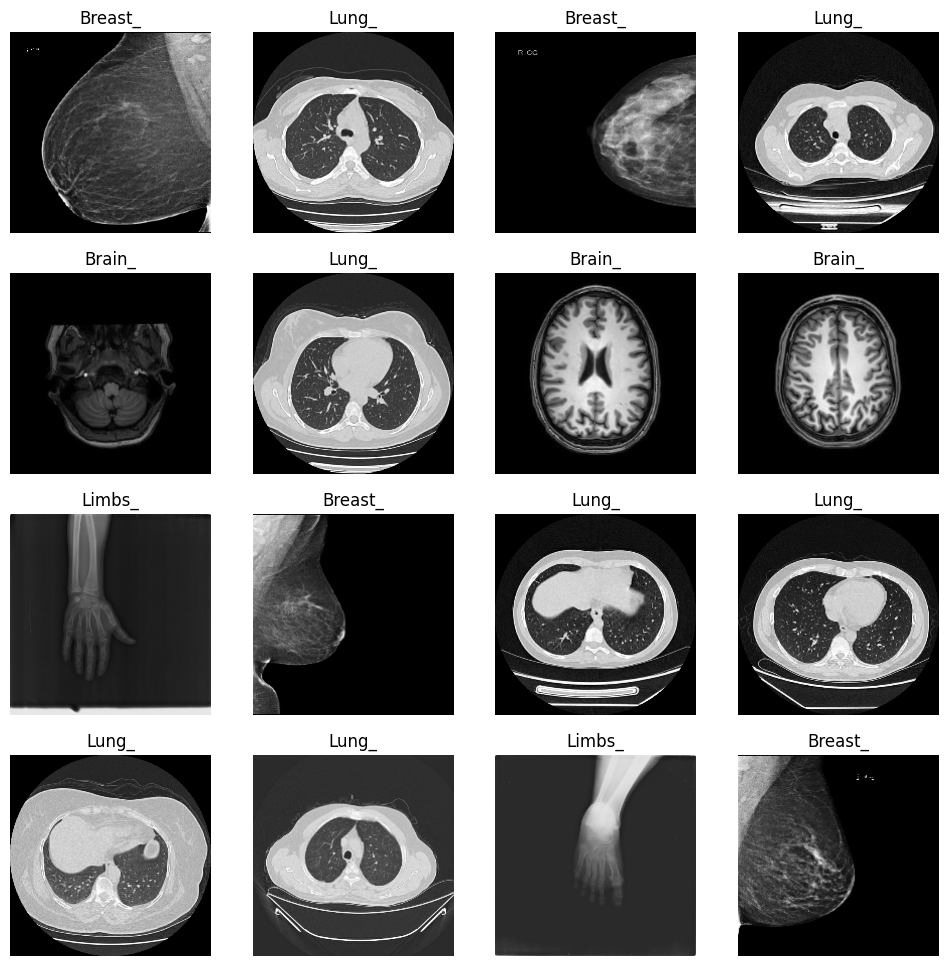

In [10]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [11]:
testing_dataset = (
    test_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [12]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)


In [13]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)


In [14]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [15]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

c:\Users\homos\.vscode\python\Bassathalk.py\ai\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 196, 196, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 196, 196, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35344)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    36,193,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,332,564 (138.60 MB)

 Trainable params: 36,330,216 (138.59 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [16]:
metrics=[CategoricalAccuracy(name='accuracy')]

In [17]:
checkpoint_callback=ModelCheckpoint(
    "basel.weights.h5",monitor="val_accuracy",verbose=0,save_best_only=True,
    save_weights_only=True,mode="auto",save_freq=1)

In [18]:
es_callback=EarlyStopping(
    monitor = "val_loss", min_delta=.01,patience=3,verbose=1,mode="auto"
    ,baseline=None,restore_best_weights=True)


In [19]:
lenet_model.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


In [14]:
lenet_model = tf.keras.models.load_model("models\my_model.keras")

In [21]:
lenet_model.evaluate(testing_dataset)

988/988 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8837 - loss: 3.6646


[3.713513135910034, 0.8613360524177551]

In [22]:
label=[]
inp=[]
for x,y in testing_dataset.as_numpy_iterator():
    label.append(y)
    inp.append(x)


In [23]:
print(np.array(label)[:,0,:].shape)

(988, 4)


In [24]:
np.array(inp)[:,0,...].shape

(988, 200, 200, 3)

In [25]:

lenet_model.predict(np.array(inp)[:,0,...]).shape

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


(988, 4)

In [26]:
true_labels=np.array(label)[:,0,:]

In [27]:
predicted_label=lenet_model.predict(np.array(inp)[:,0,...])

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step


In [28]:
true_labels=(np.argmax(true_labels,axis=-1))

In [29]:
predicted_label=(np.argmax(predicted_label,axis=-1))

[[173  74   0   0]
 [  0 245   2   0]
 [  0   0 247   0]
 [  0  50  11 186]]


Text(0.5, 36.72222222222221, 'predicted')

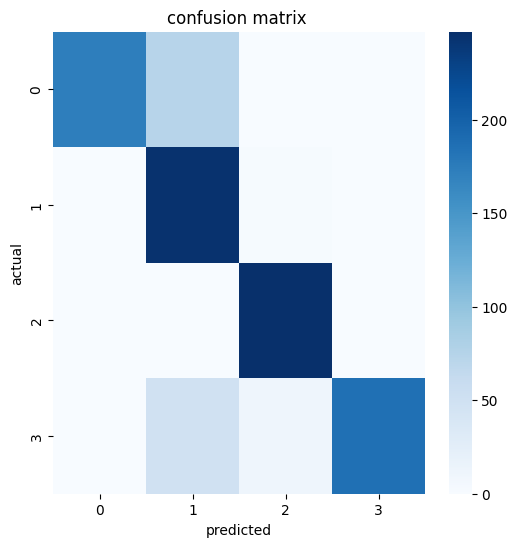

In [30]:

cm=confusion_matrix(true_labels,predicted_label)
print(cm)
plt.figure(figsize=(6,6))
sns.heatmap(cm,cmap='Blues')
plt.title("confusion matrix ")
plt.ylabel("actual")
plt.xlabel("predicted")

In [31]:

precision_macro = precision_score(true_labels, predicted_label, average='macro')
recall_macro = recall_score(true_labels, predicted_label, average='macro')
f1_macro = f1_score(true_labels, predicted_label, average='macro')

precision_micro = precision_score(true_labels, predicted_label, average='micro')
recall_micro = recall_score(true_labels, predicted_label, average='micro')
f1_micro = f1_score(true_labels, predicted_label, average='micro')

precision_weighted = precision_score(true_labels, predicted_label, average='weighted')
recall_weighted = recall_score(true_labels, predicted_label, average='weighted')
f1_weighted = f1_score(true_labels, predicted_label, average='weighted')

# Display the results
print(f"Macro Precision: {precision_macro}, Macro Recall: {recall_macro}, Macro F1: {f1_macro}")
print(f"Micro Precision: {precision_micro}, Micro Recall: {recall_micro}, Micro F1: {f1_micro}")
print(f"Weighted Precision: {precision_weighted}, Weighted Recall: {recall_weighted}, Weighted F1: {f1_weighted}")


Macro Precision: 0.9034891598915988, Macro Recall: 0.8613360323886641, Macro F1: 0.8631863613676546
Micro Precision: 0.861336032388664, Micro Recall: 0.861336032388664, Micro F1: 0.861336032388664
Weighted Precision: 0.9034891598915988, Weighted Recall: 0.861336032388664, Weighted F1: 0.8631863613676546


In [8]:
test_image=cv2.imread(r"finalTest_\Brst1.jpg")
im=tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(im),axis= -1).numpy()[0]])
print((lenet_model(im)))

Breast_
tf.Tensor([[0.0170038  0.27131203 0.0070603  0.7046239 ]], shape=(1, 4), dtype=float32)


tf.Tensor([[1.6578076e-02 9.2669684e-01 7.3802809e-04 5.5987123e-02]], shape=(1, 4), dtype=float32)


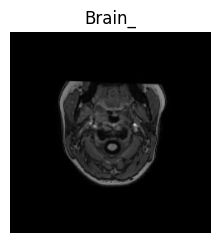

In [107]:
plt.figure(figsize = (12,12))
for images, labels in testing_dataset.take(1):
  num_images = images.shape[0]
  for i in range( min(16, num_images)):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")
    print(lenet_model(images))

In [10]:
lenet_model.save('D:/besooo/SBME/Anatomy/Tasks/OrgoVision/my_model.keras')

In [18]:
import cv2
import tensorflow as tf
import tkinter as tk
from tkinter import filedialog, ttk, messagebox
from PIL import Image, ImageTk
import threading

class OrgoVisionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("OrgoVision")
        self.root.geometry("800x900")
        self.root.configure(bg='#f0f0f0')  # Light gray background
        
        # Configure grid weight
        self.root.grid_rowconfigure(1, weight=1)
        self.root.grid_columnconfigure(0, weight=1)
        
        # Create main frames
        self.create_title_frame()
        self.create_image_frame()
        self.create_control_frame()
        self.create_result_frame()

    def create_title_frame(self):
        # Title Frame
        title_frame = tk.Frame(self.root, bg='#f0f0f0', pady=20)
        title_frame.grid(row=0, column=0, sticky='ew')
        
        # Main title
        title_label = tk.Label(
            title_frame,
            text="OrgoVision",
            font=("Helvetica", 24, "bold"),
            bg='#f0f0f0',
            fg='#2c3e50'
        )
        title_label.pack()
        
        # Subtitle
        subtitle_label = tk.Label(
            title_frame,
            text="Advanced Organ Recognition System",
            font=("Helvetica", 12),
            bg='#f0f0f0',
            fg='#7f8c8d'
        )
        subtitle_label.pack()

    def create_image_frame(self):
        # Image Display Frame
        self.image_frame = tk.Frame(
            self.root,
            bg='white',
            padx=20,
            pady=20,
            highlightthickness=1,
            highlightbackground='#dcdde1'
        )
        self.image_frame.grid(row=1, column=0, padx=50, sticky='nsew')
        
        # Image placeholder
        self.image_label = tk.Label(
            self.image_frame,
            text="No image uploaded",
            font=("Helvetica", 12),
            bg='white',
            width=600,
            height=400
        )
        self.image_label.pack(expand=True, fill='both')

    def create_control_frame(self):
        # Control Frame
        control_frame = tk.Frame(self.root, bg='#f0f0f0', pady=20)
        control_frame.grid(row=2, column=0, sticky='ew')
        
        # Upload Button
        style = ttk.Style()
        style.configure(
            'Custom.TButton',
            font=('Helvetica', 12),
            padding=10
        )
        
        self.upload_button = ttk.Button(
            control_frame,
            text="Upload Image",
            style='Custom.TButton',
            command=self.browse_image
        )
        self.upload_button.pack(pady=10)
        
        # Loading label
        self.loading_label = tk.Label(
            control_frame,
            text="",
            font=("Helvetica", 10),
            bg='#f0f0f0',
            fg='#3498db'
        )
        self.loading_label.pack()

    def create_result_frame(self):
        # Results Frame
        result_frame = tk.Frame(
            self.root,
            bg='white',
            padx=20,
            pady=20,
            highlightthickness=1,
            highlightbackground='#dcdde1'
        )
        result_frame.grid(row=3, column=0, padx=50, pady=(0, 20), sticky='ew')
        
        # Prediction result
        self.result_label = tk.Label(
            result_frame,
            text="Prediction: ",
            font=("Helvetica", 14, "bold"),
            bg='white',
            fg='#2c3e50'
        )
        self.result_label.pack(pady=5)
        
        # Confidence score
        self.confidence_label = tk.Label(
            result_frame,
            text="Confidence: ",
            font=("Helvetica", 12),
            bg='white',
            fg='#2c3e50'
        )
        self.confidence_label.pack(pady=5)

    def browse_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image Files", "*.jpg *.jpeg *.png")]
        )
        if file_path:
            self.show_loading_message()
            threading.Thread(target=self.process_image, args=(file_path,)).start()

    def process_image(self, image_path):
        try:
            # Get prediction and confidence score
            prediction, confidence, test_image = self.predict_image(image_path)
            
            # Update GUI elements in the main thread
            self.root.after(0, self.update_gui, prediction, confidence, test_image)
        except Exception as e:
            self.root.after(0, self.show_error, str(e))

    def predict_image(self, image_path):
        try:
            # Read and process the image
            test_image = cv2.imread(image_path)
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
            im = tf.constant(test_image, dtype=tf.float32)
            im = tf.expand_dims(im, axis=0)
            
            # Get the prediction and confidence scores
            predictions = lenet_model(im).numpy()
            predicted_class_index = tf.argmax(predictions, axis=-1).numpy()[0]
            predicted_class = CONFIGURATION["CLASS_NAMES"][predicted_class_index]
            
            # Confidence of the predicted class (as a percentage)
            confidence_score = predictions[0][predicted_class_index] * 100
            
            return predicted_class, confidence_score, test_image
        except Exception as e:
            raise ValueError(f"Error processing image: {e}")

    def update_gui(self, prediction, confidence, test_image):
        self.result_label.config(text=f"Prediction: {prediction}")
        self.confidence_label.config(text=f"Confidence: {confidence:.2f}%")
        self.display_image(test_image)
        self.hide_loading_message()

    def display_image(self, image):
        # Convert image for display
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = Image.fromarray(image)
        
        # Calculate scaling factor to fit the frame while maintaining aspect ratio
        display_width = 600
        display_height = 400
        
        # Resize image while maintaining aspect ratio
        image.thumbnail((display_width, display_height), Image.Resampling.LANCZOS)
        
        # Convert to PhotoImage
        photo = ImageTk.PhotoImage(image)
        
        # Update the label
        self.image_label.config(image=photo)
        self.image_label.image = photo  # Keep a reference

    def show_loading_message(self):
        self.loading_label.config(text="Processing Image...")
        self.upload_button.configure(state='disabled')

    def hide_loading_message(self):
        self.loading_label.config(text="")
        self.upload_button.configure(state='normal')

    def show_error(self, message):
        messagebox.showerror("Error", message)
        self.hide_loading_message()

# Create and run the application
if __name__ == "__main__":
    root = tk.Tk()
    app = OrgoVisionApp(root)
    root.mainloop()